# **Multi-Label Emotion Classification with BERT and PyTorch Lightning**

In this advanced deep learning project, I developed a multi-label emotion classification model using the GoEmotions dataset. The task involved detecting multiple emotions expressed within a single text sample. To address this, I fine-tuned a pre-trained BERT model rather than training from scratch, utilizing the power of transfer learning for natural language understanding.

The implementation utilized PyTorch Lightning to streamline model training, Weights & Biases (W&B) for performance logging and visualization, and Optuna for systematic hyperparameter optimization. The project emphasized efficient data preprocessing, robust training with checkpointing and early stopping, and detailed evaluation using key metrics including accuracy, precision, recall, and F1-score.

The steps of how we're doing model training is:

- Step 1: Data selection and Preprocessing -
- Step 2: Model Model Selection & Implementation
- Step 3: Model Training
- Step 4: Reporting
- Step 5: Hyperparameter Tuning
- Step 6: Model Evaluation
- Step 7: Reflection

In [3]:
# Install necessary packages for the project. -q flag makes pip install quitely without giving verbose output

!pip install datasets torch torchvision pytorch-lightning transformers datasets optuna wandb scikit-learn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.2 MB/s eta 0:00:00


## STEP 1: Data Selection, Exploration and Preprocessing
Import the GoEmotions dataset from HuggingFace. This is a multi-label emotion classification dataset to use for sentiment analysis. We map the 27 emotions to sentiment polarity.
This dataset contains over 58,000 Reddit comments (from diverse subreddits) annotated with 27 fine-grained emotions plus a neutral label. Each comment can express multiple emotions simultaneously (multi-label classification).



In [4]:
# Data Collection

from datasets import load_dataset

dataset = load_dataset('google-research-datasets/go_emotions', 'raw')
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

raw/train-00000-of-00001.parquet:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/211225 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
        num_rows: 211225
    })
})


## Exploring the Dataset

In [5]:
# First, let's see what columns are in the dataset

print("Dataset keys:")
print(dataset['train'].features)
print("\nColumn names:")
print(dataset['train'].column_names)

# Checking a sample
print("\nSample data:")
print(dataset['train'][0])

Dataset keys:
{'text': Value('string'), 'id': Value('string'), 'author': Value('string'), 'subreddit': Value('string'), 'link_id': Value('string'), 'parent_id': Value('string'), 'created_utc': Value('float32'), 'rater_id': Value('int32'), 'example_very_unclear': Value('bool'), 'admiration': Value('int32'), 'amusement': Value('int32'), 'anger': Value('int32'), 'annoyance': Value('int32'), 'approval': Value('int32'), 'caring': Value('int32'), 'confusion': Value('int32'), 'curiosity': Value('int32'), 'desire': Value('int32'), 'disappointment': Value('int32'), 'disapproval': Value('int32'), 'disgust': Value('int32'), 'embarrassment': Value('int32'), 'excitement': Value('int32'), 'fear': Value('int32'), 'gratitude': Value('int32'), 'grief': Value('int32'), 'joy': Value('int32'), 'love': Value('int32'), 'nervousness': Value('int32'), 'optimism': Value('int32'), 'pride': Value('int32'), 'realization': Value('int32'), 'relief': Value('int32'), 'remorse': Value('int32'), 'sadness': Value('int32

In [6]:
emotion_columns = [col for col in dataset['train'].column_names
                   if col not in ['text', 'id', 'author', 'subreddit', 'link_id',
                                  'parent_id', 'created_utc', 'rater_id', 'example_very_unclear']]

print(f"Number of emotion columns: {len(emotion_columns)}")
print(f"Emotions: {emotion_columns}")

# EMOTIONS list
EMOTIONS = emotion_columns

Number of emotion columns: 28
Emotions: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


## Define Emotion Labels and Custom Dataset

We built custom dataset here because GoEmotions has 28 emotions, and a text can have multiple emotions simultaneously (e.g., a comment can be both "amusing" and "surprising"). Standard datasets don't handle this automatically.

Text Preprocessing: Raw text needs to be tokenized into numbers that BERT understands. The custom dataset handles:

- Converting text to token IDs
- Adding special tokens ([CLS], [SEP])
- Padding/truncating to fixed length
- Creating attention masks

We do label encoding as emotions need to be converted from the dataset format into a 28-dimensional binary vector (e.g., [0, 1, 0, 1, 0, ...] where 1 = emotion present). The Dataset class integrates seamlessly with PyTorch's DataLoader for batching, shuffling, and parallel loading during training. Without a custom dataset, we'd have had to manually preprocess every batch during training which makes code messy and inefficient.

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import numpy as np

# Define all 28 emotion labels (27 emotions + neutral)
EMOTIONS = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

print(f"Total emotions: {len(EMOTIONS)}")

# Custom PyTorch dataset for GoEmotions
class GoEmotionsDataset(Dataset):
    """
      A custom dataset class to tokenize text and create multi-label emotion vectors.
      Each sample includes:
        - input_ids: token IDs from BERT tokenizer
        - attention_mask: mask to ignore padding tokens
        - labels: 28-dim binary vector (1 if emotion applies)
    """

    def __init__(self, data, tokenizer, max_len=48):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

      # max_len was adjusted from the result of the text analysis done few steps below - the longest text is only 33 words so ~48 words would cover 100% of the data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        text = str(item['text'])

        # Creating 28-dim binary vector for each sample
        labels = []
        for emotion in EMOTIONS:
            labels.append(float(item[emotion]))

        # Multi-label encoding for emotions
        labels = torch.tensor(labels, dtype=torch.float)

        # Tokenization converts text to BERT-compatible format
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',     # pad shorter sequences
            truncation=True,          # cut longer sequences
            return_attention_mask=True, # mask tells model which tokens are real vs padding
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

Total emotions: 28


## Data Preprocessing and Splitting
We used this splitting approach as GoEmotions dataset doesn't have a pre-split validation/test set. Manual splitting ensures consistent evaluation data.

In [8]:
def preprocess_goemotions():
    """
    Prepares tokenized train, validation, and test dataloaders for model training.
    """

    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Check dataset splits
    available_splits = list(dataset.keys())
    print(f"Available splits: {available_splits}")

    # Get train data
    full_train_data = dataset['train']

    # Create train-validation split (85/15)
    print("Creating validation split from training data...")
    train_size = int(0.85 * len(full_train_data))
    indices = list(range(len(full_train_data)))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_data = full_train_data.select(train_indices)
    val_data = full_train_data.select(val_indices)

    # Create test split from validation (50/50)
    print("Creating test split from validation data...")
    val_size = len(val_data) // 2
    val_indices_list = list(range(len(val_data)))

    new_val_indices = val_indices_list[:val_size]
    test_indices = val_indices_list[val_size:]

    new_val_data = val_data.select(new_val_indices)
    test_data = val_data.select(test_indices)
    val_data = new_val_data

    print(f"\nFinal split sizes:")
    print(f"Train: {len(train_data)}")
    print(f"Validation: {len(val_data)}")
    print(f"Test: {len(test_data)}")

    # Create Pytorch Datasets and DataLoaders
    train_dataset = GoEmotionsDataset(train_data, tokenizer)
    val_dataset = GoEmotionsDataset(val_data, tokenizer)
    test_dataset = GoEmotionsDataset(test_data, tokenizer)

    # DataLoader Configuration with 32 samples per batch in random order and no parallel loading
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,       # 'true' for training to prevent overfitting of data
        num_workers=0)
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,    # 'false' for validation/test for reproducible metrics
        num_workers=0)
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0)

    return train_loader, val_loader, test_loader, tokenizer

# Execute
train_loader, val_loader, test_loader, tokenizer = preprocess_goemotions()

print(f"\n✓ Training batches: {len(train_loader)}")
print(f"✓ Validation batches: {len(val_loader)}")
print(f"✓ Test batches: {len(test_loader)}")

# Testing a batch
batch = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"Input IDs: {batch['input_ids'].shape}")
print(f"Attention mask: {batch['attention_mask'].shape}")
print(f"Labels: {batch['labels'].shape}")  # Should be [32, 27]
print(f"\nSample label vector: {batch['labels'][0]}")
print(f"Number of active emotions in first sample: {batch['labels'][0].sum().item()}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Available splits: ['train']
Creating validation split from training data...
Creating test split from validation data...

Final split sizes:
Train: 179541
Validation: 15842
Test: 15842

✓ Training batches: 5611
✓ Validation batches: 496
✓ Test batches: 496

Batch shapes:
Input IDs: torch.Size([32, 48])
Attention mask: torch.Size([32, 48])
Labels: torch.Size([32, 28])

Sample label vector: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Number of active emotions in first sample: 1.0


## Exploratory Data Analysis: Text length analysis
This is a critical step before training to make informed hyperparameter choices. This analysis helps us choose the optimal max_length parameter for tokenization. If we set max_length too small, longer texts get truncated, losing important emotion signals and if we set max_length too large, it wastes memory and computation on padding.

In the GoEmotionsDataset class, we have used the max_length that was analyzed from this plot.

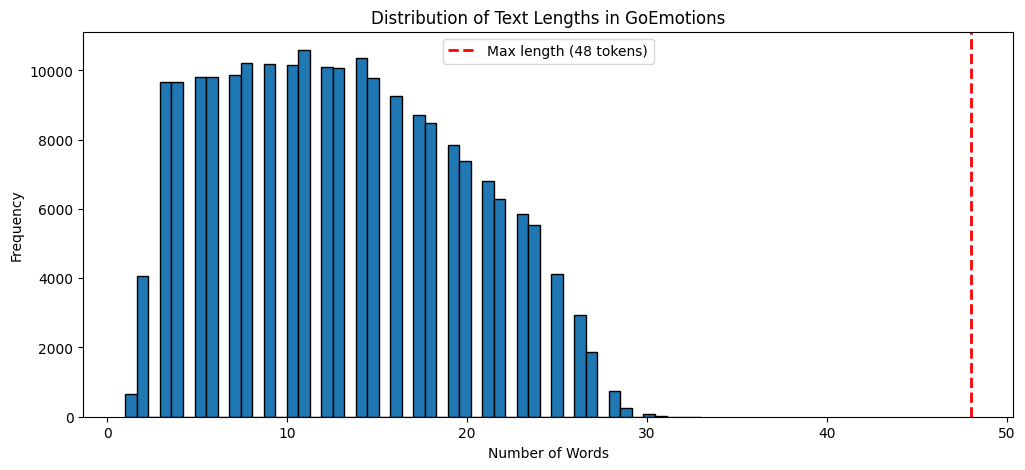

Average length: 13.00 words
Median length: 13 words
95th percentile: 24 words
Max length: 33 words


In [9]:
import matplotlib.pyplot as plt

# Analyze average word count per comment to determine optimal max_length
text_lengths = [len(text.split()) for text in dataset['train']['text']]

plt.figure(figsize=(12, 5))
plt.hist(text_lengths, bins=50, edgecolor='black')
plt.axvline(x=48, color='r', linestyle='--', label='Max length (48 tokens)', linewidth=2)
plt.title('Distribution of Text Lengths in GoEmotions')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Average length: {sum(text_lengths)/len(text_lengths):.2f} words")
print(f"Median length: {sorted(text_lengths)[len(text_lengths)//2]} words")
print(f"95th percentile: {sorted(text_lengths)[int(len(text_lengths)*0.95)]} words")
print(f"Max length: {max(text_lengths)} words")

## MODEL IMPLEMENTATION

BERT-based model was chosen for this task as emotion classification in text requires understanding linguistic text which traditional models like CNNs or RNNs often struggle to capture. BERT excels in this domain due to its bidirectional attention mechanism (understanding both left and right context simultaneously).

For this task, I fine-tuned a pre-trained BERT model by adding a dropout layer (0.3) to reduce overfitting and a linear layer to map features to 28 emotion labels. A sigmoid activation was used so the model could predict multiple emotions for each text.

In this task, a milti-label loss function was used as BCE with logits loss combine Sigmoid layer and BCELoss in one class. This is useful in datasets with varying levels of class imbalance, multiple emotions can be true in this case.


In [10]:
!pip install pytorch_lightning -q

In [11]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
from transformers import BertModel
from torchmetrics import Accuracy, Precision, Recall, F1Score

class SentimentClassifier(pl.LightningModule):
    def __init__(self, n_classes=28, learning_rate=2e-5, dropout=0.3):
        super().__init__()
        self.save_hyperparameters()

        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Classification head for multi-label (28 emotions)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

        # Loss function for multi-label classification
        self.criterion = nn.BCEWithLogitsLoss()

        # Metrics (using threshold of 0.5)
        self.train_accuracy = Accuracy(task='multilabel', num_labels=n_classes, threshold=0.5)
        self.val_accuracy = Accuracy(task='multilabel', num_labels=n_classes, threshold=0.5)
        self.test_accuracy = Accuracy(task='multilabel', num_labels=n_classes, threshold=0.5)

    def forward(self, input_ids, attention_mask):
        """
        Defines how data flows through the model.
        Called automatically during training/inference.

        Args:
          input_ids: Token IDs [batch_size, seq_len]
          attention_mask: Padding mask [batch_size, seq_len]

        Returns:
          logits: Raw predictions [batch_size, 28]
        """

        # Pass through BERT encoder
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Extract [CLS] token representation
        pooled_output = outputs.pooler_output

        # Apply dropout for regularization
        output = self.dropout(pooled_output)

        # Project to 28 emotion logits
        logits = self.classifier(output)

        return logits   # return raw scores

    # One training branch
    def training_step(self, batch, batch_idx):
        """
        Executes one training iteration on a single batch.
        Called automatically by PyTorch Lightning during training.

        Args:
            batch: Dictionary with 'input_ids', 'attention_mask', 'labels'
            batch_idx: Index of current batch

        Returns:
            loss: Training loss (Lightning auto-backpropagates this)
        """

        # Unpack batch data
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        # Forward pass - calls self.forward()
        logits = self(input_ids, attention_mask)

        # Calculate loss
        loss = self.criterion(logits, labels)   # Scalar value

        # Convert logits to probabilities for metrics
        preds = torch.sigmoid(logits)

        # Step 5: Calculate accuracy
        acc = self.train_accuracy(preds, labels.int())

        # Log metrics
        self.log('train_loss', loss,
                 prog_bar=True,   # show in progress bar
                 on_step=True,    # log every batch
                 on_epoch=True)   # log epoch average

        self.log('train_acc', acc,
                 prog_bar=True,
                 on_step=False,   # dont log every batch
                 on_epoch=True)   # only log epoch average

        # Return loss for backpropagation
        return loss


    def validation_step(self, batch, batch_idx):
        """
        Evaluates model on validation data (no gradient updates).
        Called automatically during validation phase.

        Args:
          batch: Validation batch
          batch_idx: Batch index

        Returns:
          loss: Validation loss (for monitoring only)
        """

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        # Forward pass
        logits = self(input_ids, attention_mask)

        # Calculate loss
        loss = self.criterion(logits, labels)

        # Get predictions
        preds = torch.sigmoid(logits)

        # Calculate accuracy
        acc = self.val_accuracy(preds, labels.int())

        # Log validation metrics
        self.log('val_loss', loss,
                 prog_bar=True,
                 on_step=False,
                 on_epoch=True)
        self.log('val_acc', acc,
                 prog_bar=True,
                 on_step=False, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        """
        Evaluates model on held-out test data.
        Called when you run: trainer.test(model, test_loader)

        Args:
        batch: Test batch
        batch_idx: Batch index

        Returns:
        loss: Test loss
        """

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        # Forward pass
        logits = self(input_ids, attention_mask)

        # Calculate loss
        loss = self.criterion(logits, labels)

        # Get predictions
        preds = torch.sigmoid(logits)

        # Calculate accuracy
        acc = self.test_accuracy(preds, labels.int())

        # Log test metrics - no per-batch logging, only final average
        self.log('test_loss', loss,
                 on_step=False,
                 on_epoch=True)
        self.log('test_acc', acc,
                 on_step=False,
                 on_epoch=True)

        return loss

    def configure_optimizers(self):
        """
        Defines optimizer and learning rate scheduler.
        Called once at the start of training.

        Returns:
        Dictionary with optimizer and scheduler config
        """

        # Initialize optimizer
        # AdamW provides better weight decay for large models
        optimizer = torch.optim.AdamW(
            self.parameters(),  # all model parameters
            lr=self.hparams.learning_rate # 2e-5
            )

        # Initialize learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2
        )

        # Return configuration
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss', # Metric to watch
                'interval': 'epoch',      # Check every epoch
                'frequency': 1            # Check every 1 epoch
            }
        }

# Initialize model
model = SentimentClassifier(
    n_classes=28,
    learning_rate=2e-5,
    dropout=0.3)

print("Model initialized!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model initialized!
Total parameters: 109,503,772
Trainable parameters: 109,503,772


## Testing the model

In [12]:
# Test with one batch
batch = next(iter(train_loader))
logits = model(batch['input_ids'], batch['attention_mask'])

print(f"\nModel output shape: {logits.shape}")  # Should be [32, 28]
print(f"Sample logits (first 5 emotions): {logits[0][:5]}")

# Convert to probabilities
probs = torch.sigmoid(logits)
print(f"\nSample probabilities (first 5 emotions): {probs[0][:5]}")

# Get predictions (threshold = 0.5)
predictions = (probs > 0.5).int()
print(f"\nSample predictions (first 10 emotions): {predictions[0][:10]}")
print(f"Actual labels (first 10 emotions): {batch['labels'][0][:10].int()}")


Model output shape: torch.Size([32, 28])
Sample logits (first 5 emotions): tensor([-0.5832,  0.1710, -0.9568, -0.1591,  0.4427], grad_fn=<SliceBackward0>)

Sample probabilities (first 5 emotions): tensor([0.3582, 0.5427, 0.2775, 0.4603, 0.6089], grad_fn=<SliceBackward0>)

Sample predictions (first 10 emotions): tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 1], dtype=torch.int32)
Actual labels (first 10 emotions): tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)


### Experiment Tracking with Weights and Biases

W&B models are used to track and visualize all ML experiments. They are also used to manage model versions  and optimize hyperparameters.
This setup helps us automate experiment tracking: recording training metrics, model checkpoints, and configurations in one place on our W&B dashboard for easy visualization and comparison.



In [13]:
# Install W&B
!pip install wandb -q

# Login to W&B
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aakritidh208 (aakritidh208-texas-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [16]:
# Testing if wandb is logging something

import wandb
wandb.log({"test_metric": 0.5})

## Setting up W&B logger


**WandbLogger()** initializes a logger that records everything happening during training (loss, accuracy, learning rate, etc.) and sends it to our W&B dashboard.

**wandb_logger.experiment.config.update({...})** logs key hyperparameters so that you can track which settings were used in each run, compare performance across experiments and reproduce results later.



In [17]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Initialize W&B logger
wandb_logger = WandbLogger(
    project='goemotions-sentiment-analysis',
    name='bert-multilabel-baseline',
    log_model=True
)

# Log hyperparameters
wandb_logger.experiment.config.update({
    "model": "bert-base-uncased",
    "task": "multi-label classification",
    "num_emotions": 28,
    "learning_rate": 2e-5,
    "batch_size": 32,
    "max_length": 48,
    "dropout": 0.3
})

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


### Setup callbacks

This step is done to save the best model and stop training early if it stops improving.

In [27]:
# Connects your Colab environment to Google Drive so you can save models permanently
from google.colab import drive
drive.mount('/content/drive')

# Model checkpoint - saves the model when validation loss (val_loss) improves
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content/drive/MyDrive/checkpoints/',
    filename='goemotions-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min'
)

# Early stopping - stops training if no improvement
# This prevents overfitting and saves training time
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Hyperparameter Tuning with Optuna

We use Optuna to automatically find the best combination of hyperparameters (like learning rate, dropout, and batch size) that minimize validation loss and improve overall model performance. It saves time compared to manual trial-and-error.

Different hyperparameters impact model's performance differently.


- Learning rate controls how fast the model learns. Too high causes instability and too low makes training slow.

- Dropout prevents overfitting by randomly turning off neurons.

- Batch size affects training stability and memory use.

- Number of epochs controls how long the model trains: too few underfit, too many overfit.





In [19]:
# Install Optuna
!pip install optuna optuna-integration -q
!pip install -U pytorch-lightning -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.7 MB/s eta 0:00:00


In [20]:
# def objective(trial):
#     # Suggest hyperparameters
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
#     dropout = trial.suggest_float('dropout', 0.1, 0.5)
#     batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

#     # Recreate dataloaders with new batch size
#     # train_loader_optuna = DataLoader(
#     #     GoEmotionsDataset(dataset['train'].select(range(int(0.85 * len(dataset['train'])))), tokenizer),
#     #     batch_size=batch_size,
#     #     shuffle=True,
#     #     num_workers=0
#     # )

#     # val_loader_optuna = DataLoader(
#     #     GoEmotionsDataset(dataset['train'].select(range(int(0.85 * len(dataset['train'])), len(dataset['train']))), tokenizer),
#     #     batch_size=batch_size,
#     #     shuffle=False,
#     #     num_workers=0
#     # )

#     train_subset = dataset['train'].shuffle(seed=42).select(range(2000))
#     val_subset = dataset['train'].shuffle(seed=43).select(range(500))


#     train_loader_optuna = DataLoader(
#     GoEmotionsDataset(train_subset, tokenizer),
#     batch_size=batch_size,
#     shuffle=True
#     )
#     val_loader_optuna = DataLoader(
#     GoEmotionsDataset(val_subset, tokenizer),
#     batch_size=batch_size,
#     shuffle=False
#     )


#     # Initialize model
#     model = SentimentClassifier(
#         n_classes=28,
#         learning_rate=learning_rate,
#         dropout=dropout
#     )

#     # Trainer for hyperparameter search (without pruning callback)
#     trainer = pl.Trainer(
#         max_epochs=3,
#         accelerator='gpu' if torch.cuda.is_available() else 'cpu',
#         devices=1,
#         logger=False,
#         enable_checkpointing=False,
#         callbacks=[],  # Empty callbacks list
#         enable_progress_bar=False
#     )

#     # Train
#     trainer.fit(model, train_loader_optuna, val_loader_optuna)

#     # Return validation loss
#     return trainer.callback_metrics["val_loss"].item()


def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    This function trains and evaluates a BERT-based multi-label emotion classifier,
    returning the validation F1 score as the metric to maximize.
    """

    # Hyperparameters search space
    # Optuna will suggest different values for each trial to find the best combination
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_epochs = trial.suggest_int("num_epochs", 2, 5)


    # Use smaller subset of data for faster trials
    train_subset = dataset['train'].shuffle(seed=42).select(range(2000))
    val_subset = dataset['train'].shuffle(seed=43).select(range(500))

    # Reuse pre-tokenized data if possible
    train_loader_optuna = DataLoader(
        GoEmotionsDataset(train_subset, tokenizer),
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    val_loader_optuna = DataLoader(
        GoEmotionsDataset(val_subset, tokenizer),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    # Initialize model with hyperparameters from the current trial
    model = SentimentClassifier(
        n_classes=28,
        learning_rate=learning_rate,
        dropout=dropout
    )

    # # ✅ Add Optuna pruning callback
    # from pytorch_lightning.callbacks import EarlyStopping
    # from optuna.integration import PyTorchLightningPruningCallback


    # Trainer handles training, validation, logging and early stopping. Use only 1 epoch for fast search
    trainer = pl.Trainer(
        max_epochs=1,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        logger=False,
        enable_checkpointing=False,
        enable_progress_bar=False,
        deterministic = False,   # for reproducibility
        callbacks=[]
    )

    # Train the model on training + validation data
    trainer.fit(model, train_loader_optuna, val_loader_optuna)

    # Return validation loss for Optuna to minimize
    val_loss = trainer.callback_metrics.get("val_loss")
    if val_loss is None:
        return float('inf')  # handle missing metric safely
    return val_loss.item()

## Run Optuna Study

Here we use the Optuna framework to automate hyperparameter tuning. the create_study() function sets up an optimiztion experiment. The function objective() defines how to train and evaluate the model for one trial. Each trial tries a new combination of hyperparameters (like different learning rates, dropout, etc.). After all the trail finishes, Optuna finds the best trial with lowest validation loss and prints the optimal hyperparameters used in that trial.

In [21]:
import optuna

# Create study
study = optuna.create_study(
    direction='minimize',
    study_name='goemotions-hyperparam-search',
    storage="sqlite:///optuna_study.db",  # saves progress to a local DB file
    load_if_exists=True
    # pruner=optuna.pruners.MedianPruner()
)

# Run optimization
print("Starting hyperparameter search...")
study.optimize(objective, n_trials=3)

# Display best results
print("\n" + "="*50)
print("BEST HYPERPARAMETERS")
print("="*50)
print(f"Best trial: {study.best_trial.number}")
print(f"Best validation loss: {study.best_trial.value:.4f}")
print(f"\nBest hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")


[I 2025-11-12 01:25:57,475] A new study created in RDB with name: goemotions-hyperparam-search


Starting hyperparameter search...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | bert           | BertModel          | 109 M  | eval 
1 | dropout        | Dropout            | 0      | train
2 | classifier     | Linear             | 21.5 K | train
3 | criterion      | BCEWithLogitsLoss  | 0      | train
4 | train_accuracy | MultilabelAccuracy | 0      | train
5 | val_accuracy   | MultilabelAccuracy | 0      | train
6 | test_accuracy  | MultilabelAccuracy | 0      | train
--------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.015   Total estimated model params s


BEST HYPERPARAMETERS
Best trial: 0
Best validation loss: 0.1667

Best hyperparameters:
  learning_rate: 3.0171413419754607e-05
  dropout: 0.4125400195636889
  batch_size: 16
  num_epochs: 4


In [22]:
# Printing the trial details

import pandas as pd

df = pd.DataFrame(study.trials_dataframe(attrs=("number", "value", "params", "state")))
print(df)

   number     value  params_batch_size  params_dropout  params_learning_rate  \
0       0  0.166742                 16        0.412540              0.000030   
1       1  0.270700                 64        0.121064              0.000035   
2       2  0.348424                 32        0.261761              0.000012   

   params_num_epochs     state  
0                  4  COMPLETE  
1                  3  COMPLETE  
2                  2  COMPLETE  


In [23]:
# Printing only the best trials from the study

best_params = study.best_params
print(best_params)

{'learning_rate': 3.0171413419754607e-05, 'dropout': 0.4125400195636889, 'batch_size': 16, 'num_epochs': 4}


In [24]:
# Get the best hyperparameters
best_batch_size = best_params['batch_size']

# Create the final training and validation DataLoader to match the best batch size
train_loader_final = DataLoader(
    GoEmotionsDataset(dataset['train'].select(range(int(0.85 * len(dataset['train'])))), tokenizer),
    batch_size=best_batch_size, # optimal batch_size from Optuna
    shuffle=True,
    num_workers=0
)

val_loader_final = DataLoader(
    GoEmotionsDataset(dataset['train'].select(range(int(0.85 * len(dataset['train'])), len(dataset['train']))), tokenizer),
    batch_size=best_batch_size,
    shuffle=False,
    num_workers=0
)


In [25]:
# Creating the final model after hyperparameter tuning using best params found during Optuna search
model_final = SentimentClassifier(
    n_classes=28,
    learning_rate=best_params['learning_rate'],
    dropout=best_params['dropout']
)


In [26]:
# Final model training

trainer = pl.Trainer(
    max_epochs=2,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
)

trainer.fit(model_final, train_loader_final, val_loader_final)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /content/drive/MyDrive/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | bert           | BertModel          | 109 M  | eval 
1 | dropout        | Dropout            | 0      | train
2 | classifier     | Linear             | 21.5 K | train
3 | criterion      | BCEWithLogitsLoss  | 0      | train
4 | train_accuracy | MultilabelAccuracy | 0      | train
5 | val_accuracy   | MultilabelAccuracy | 0      | train
6 | test_accuracy  | MultilabelAccuracy | 0      | train
----------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:527: Found 228 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.112


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.111
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [30]:
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.47343406081199646    │
│         test_loss         │    0.7072081565856934     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7072081565856934, 'test_acc': 0.47343406081199646}]

In [31]:
import torch
from tqdm import tqdm

model_final.eval()  # set model to evaluation mode
y_true, y_pred = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(model_final.device)
        attention_mask = batch["attention_mask"].to(model_final.device)
        labels = batch["labels"].cpu().numpy()

        outputs = model_final(input_ids, attention_mask)
        preds = torch.sigmoid(outputs).cpu().numpy()  # convert logits to probabilities
        preds = (preds > 0.5).astype(int)  # threshold probabilities into binary predictions

        y_true.extend(labels)
        y_pred.extend(preds)


100%|██████████| 496/496 [21:17<00:00,  2.58s/it]


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("===== Test Performance =====")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


===== Test Performance =====
Accuracy:  0.2255
Precision: 0.5989
Recall:    0.1663
F1-Score:  0.2195


In [33]:
import wandb

wandb.log({
    "test_accuracy": accuracy,
    "test_precision": precision,
    "test_recall": recall,
    "test_f1": f1
})
